In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from sen12ms_dataloader import sen12ms
from pytorch_unet import SimpleLinear
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss
import copy
import time
from fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.softmax(pred, dim=0)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, calc_loss, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    mb = master_bar(range(num_epochs))

    loss_curve = []
    x = []
    
    loss_curve_val = []
    x_val = []
    
    num_samples = len(dataloaders['train'].dataset)
    
    for epoch in mb:
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        try:
            for phase in ['train', 'val']:
                if phase == 'train':
                    scheduler.step()
                    for param_group in optimizer.param_groups:
                        print("LR", param_group['lr'])

                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                metrics = defaultdict(float)
                epoch_samples = 0
             
                for inputs, labels in progress_bar(dataloaders[phase], parent=mb):
                    inputs = inputs.to(device)
                    labels = labels.to(device)             

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = calc_loss(outputs, labels, metrics)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    # statistics
                    epoch_samples += inputs.size(0)
                    
                    if phase == 'train':
                        sample_loss = metrics['loss']/epoch_samples
                        x.append(epoch*num_samples + epoch_samples)
                        loss_curve.append(sample_loss)
                    
                    if epoch_samples % 10:
                        x_bounds = [0, epoch_samples]
                        y_bounds = [min(loss_curve),0.85]

                        mb.update_graph([[x, loss_curve ], [x_val, loss_curve_val ]], x_bounds, y_bounds)
                    mb.child.comment = "Loss: {}".format(metrics['loss'] / epoch_samples)
                    #pbar.set_description("Loss %f" % (metrics['loss'] / epoch_samples) )

                print_metrics(metrics, epoch_samples, phase)
                epoch_loss = metrics['loss'] / epoch_samples
                
                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    print("saving best model")
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model, "model_{}.pt".format(epoch))
                    
                x_val.append(epoch*num_samples)
                loss_curve_val.append(epoch_loss)

        except KeyboardInterrupt:
            break

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    torch.save(model, "model_final.pt".format(epoch))
    np.save(np.array([[x, loss_curve ], [x_val, loss_curve_val ]]))

    # load best model weights
    
    return model, (x, loss_curve)

In [13]:
dataset = sen12ms("/mnt/data", rgb=False, sar=False)

# use same transform for train/val for this example
val_length = int(0.2*len(dataset))
train_length = len(dataset) - val_length
train_set, val_set = torch.utils.data.random_split(dataset, (train_length, val_length))

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 128
input_channels = dataset[0][0].shape[0]
num_class = 18

dataloaders = {
    'train':  DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=15),
    'val':  DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=15)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

print(train_length, val_length)

144530 36132


Epoch 0/39
----------
LR 0.001


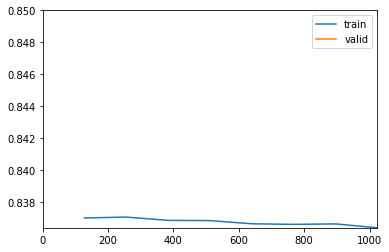

Best val loss: 10000000000.000000


TypeError: save() missing 1 required positional argument: 'arr'

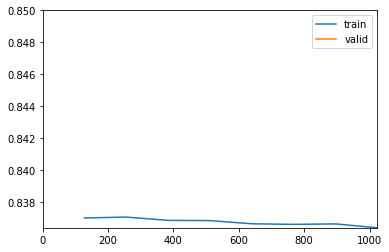

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleLinear(input_channels, num_class).to(device)

optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model, curve = train_model(model, optimizer_ft, exp_lr_scheduler, calc_loss, num_epochs=40)

In [ ]:
inputs, labels = next(iter(dataloaders['val']))
model.eval()
inputs = inputs.to(device)
outputs = model(inputs)

In [45]:
import os, pathlib
path = pathlib.PosixPath("/mnt/data")
mean_optical = np.load(os.fspath(path/"total_optical_image.npy"))

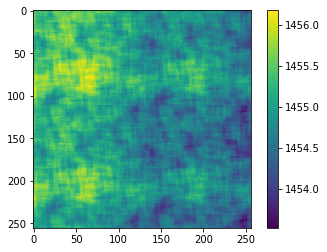

In [48]:
plt.imshow(mean_optical[0])
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


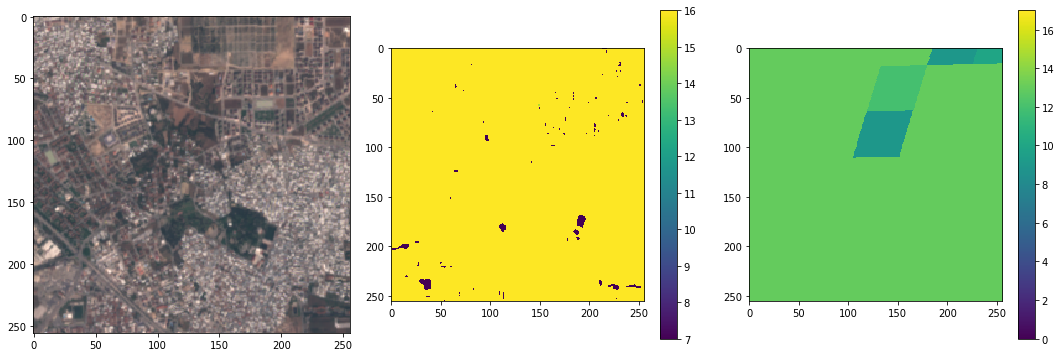

In [71]:
i=25

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(inputs[i].cpu().numpy()[[3,2,1]].transpose(1,2,0)+mean_optical[[3,2,1]].transpose(1,2,0)/4096)

plt.subplot(132)
plt.imshow(np.argmax(torch.softmax(outputs[i].cpu().detach(), dim=0), axis=0))
plt.colorbar()

plt.subplot(133)
plt.imshow(np.argmax(labels[i], axis=0), vmin=0, vmax=17)
plt.colorbar()

plt.tight_layout()